In [1]:
import pandas as pd
import numpy as np
import sqlite3
import re
import unicodedata
from pathlib import Path
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

def clean_health_dataset(
    csv_path: str,
    output_path: str = 'cleaned_global_health_data.csv',
    sqlite_db_path: str = None,
    save_to_sqlite: bool = False
):
    """
    Specialized ETL pipeline for the Global Health Dataset.
    Handles issues specific to this dataset:
    • Special characters in country names (It@lĄ, T?u?r?k?e?y?, etc.)
    • Mixed numeric formatting (quotes, commas as decimals)
    • Disease name inconsistencies
    • Missing values in age groups and demographic columns
    • Inconsistent vaccine/treatment availability labels
    """
    print("=" * 80)
    print("GLOBAL HEALTH DATASET CLEANING PIPELINE")
    print("=" * 80)
    # ---------- 1. EXTRACTION ----------
    print("\n1. EXTRACTING DATA...")
    # Careful handling of mixed types and encoding fallback
    df = None
    encodings_to_try = ['utf-8', 'latin1', 'cp1252']
    for enc in encodings_to_try:
        try:
            df = pd.read_csv(
                csv_path,
                encoding=enc,
                low_memory=False,
                na_values=['', 'NaN', 'NA', 'NULL', 'None', 'nan', 'N/A', 'n/a', '~none~', '?', '-'],
                keep_default_na=True
            )
            print(f"Successfully read with encoding: {enc}")
            break
        except UnicodeDecodeError:
            print(f"Failed to read with encoding '{enc}'. Trying next...")
            continue
    if df is None:
        raise ValueError("Could not read the CSV file with any common encoding (UTF-8, Latin-1, CP1252). "
                         "Try opening the file in a text editor to check its encoding, or specify a custom one.")
    
    print(f"Original shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nFirst 5 rows (original):")
    print(df.head())
    # ---------- 2. TRANSFORMATION ----------
    print("\n" + "=" * 80)
    print("2. TRANSFORMING DATA...")
    print("=" * 80)
    # 2a. Clean Country Names
    print("\n2a. Cleaning country names...")
    def clean_country_name(name):
        if pd.isna(name):
            return "Unknown"
        # Remove special characters but preserve spaces and actual letters
        # Keep common punctuation like hyphens and apostrophes
        name = str(name)
        # Specific known corrections
        corrections = {
            'It@lĄ': 'Italy',
            'T?u?r?k?e?y?': 'Turkey',
            'G%rmany': 'Germany',
            'Can@da': 'Canada',
            'Mex!co': 'Mexico',
            '?r?zil': 'Brazil',
            'Ind!a': 'India'  # Just in case
        }
        # Apply known corrections
        if name in corrections:
            return corrections[name]
        # Remove problematic characters but keep normal letters, spaces, hyphens
        cleaned = re.sub(r'[^a-zA-Z\s\-\.\']', '', name)
        cleaned = cleaned.strip()
        # Capitalize properly
        if cleaned:
            parts = cleaned.split()
            cleaned = ' '.join([p.capitalize() for p in parts])
        return cleaned if cleaned else "Unknown"
    df['Country'] = df['Country'].apply(clean_country_name)
    print(f"Unique countries after cleaning: {df['Country'].nunique()}")
    print(f"Sample countries: {df['Country'].unique()[:10]}")
    # 2b. Clean Disease Names
    print("\n2b. Cleaning disease names...")
    def clean_disease_name(name):
        if pd.isna(name):
            return "Unknown"
        name = str(name).strip()
        # Remove extra spaces and weird characters
        name = re.sub(r'[^\w\s\-\(\)\']', '', name)
        # Fix specific known issues
        name = name.replace('A!DS', 'AIDS')
        name = name.replace('Influen&za', 'Influenza')
        name = name.replace('Pol!o', 'Polio')
        # Remove extra whitespace
        name = ' '.join(name.split())
        # Capitalize first letter of each word (for proper nouns)
        # Preserve acronyms like COVID-19, HIV/AIDS
        if not any(x in name.upper() for x in ['COVID', 'HIV', 'AIDS', 'SARS', 'MERS']):
            name = name.title()
        return name
    df['Disease Name'] = df['Disease Name'].apply(clean_disease_name)
    print(f"Unique diseases: {df['Disease Name'].nunique()}")
    # 2c. Clean Year column
    print("\n2c. Cleaning year data...")
    # Convert Year to integer, handle float values like 2013.00
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Year'] = df['Year'].fillna(df['Year'].median())
    df['Year'] = df['Year'].astype(int)
    # Filter to reasonable years (1900-2100)
    df = df[(df['Year'] >= 1900) & (df['Year'] <= 2100)]
    # 2d. Clean numeric columns with special formatting
    print("\n2d. Cleaning numeric columns...")
    # List of columns that should be numeric
    numeric_columns = [
        'Country_pop', 'Incidence Rate mn (%)', 'Prevalence rate (%)',
        'Mortality Rate per 100 people (%)', 'Population affected',
        'Pop_affected(Male)', 'Pop_affected(Female)', 'Ages 0-18 (%)',
        'Ages 19-35 (%)', 'Ages 36-60 (%)', 'Ages 61+ (%)',
        'Pop_affected_U (%)', 'Pop_affected_R (%)', 'Healthcare Access (%)',
        'Doctors per 1000', 'Hospital Beds per 1000', 'Recovery Rate (%)',
        'DALYs', 'Improvement in 5 Years (%)', 'Average Annual Treatment Cost (USD)',
        'Composite Health Index (CHI)', 'Per Capita Income (USD)',
        'Education Index', 'Urbanization Rate (%)'
    ]
    def clean_numeric_value(value):
        if pd.isna(value):
            return np.nan
        value_str = str(value)
        # Remove quotes and commas used as decimal separators
        value_str = value_str.replace("'", "").replace(",", ".")
        # Remove any non-numeric characters except decimal point, minus sign
        value_str = re.sub(r'[^\d\.\-]', '', value_str)
        # Handle empty strings
        if value_str == '' or value_str == '.':
            return np.nan
        try:
            return float(value_str)
        except:
            return np.nan
    for col in numeric_columns:
        if col in df.columns:
            print(f" Cleaning {col}...")
            df[col] = df[col].apply(clean_numeric_value)
    # 2e. Clean categorical columns
    print("\n2e. Cleaning categorical columns...")
    # Clean Treatment Type
    if 'Treatment type' in df.columns:
        df['Treatment type'] = df['Treatment type'].fillna('Unknown')
        df['Treatment type'] = df['Treatment type'].str.capitalize()
    # Clean Vaccine/Treatment Availability
    if 'Availability of Vaccines/Treatment' in df.columns:
        availability_map = {
            'High': 'High',
            'High ': 'High',
            'high': 'High',
            'Medium': 'Medium',
            'medium': 'Medium',
            'Low': 'Low',
            'low': 'Low',
            'None': 'None',
            'none': 'None',
            '~none~': 'None',
            'NONE': 'None',
            'None ': 'None'
        }
        def clean_availability(val):
            if pd.isna(val):
                return 'Unknown'
            val_str = str(val).strip()
            return availability_map.get(val_str, 'Medium')  # Default to Medium if unknown
        df['Availability of Vaccines/Treatment'] = df['Availability of Vaccines/Treatment'].apply(clean_availability)
    # 2f. Handle missing values
    print("\n2f. Handling missing values...")
    # Fill missing population with country-year averages
    if 'Country_pop' in df.columns:
        country_year_avg = df.groupby(['Country', 'Year'])['Country_pop'].transform('median')
        df['Country_pop'] = df['Country_pop'].fillna(country_year_avg)
        df['Country_pop'] = df['Country_pop'].fillna(df['Country_pop'].median())
        df['Country_pop'] = df['Country_pop'].astype(int)
    # Fill missing demographic percentages (should sum to ~100% across age groups)
    age_cols = ['Ages 0-18 (%)', 'Ages 19-35 (%)', 'Ages 36-60 (%)', 'Ages 61+ (%)']
    for col in age_cols:
        if col in df.columns:
            df[col] = df[col].fillna(25)  # Distribute evenly if unknown
    # Fill missing rates with disease-country averages
    rate_cols = ['Incidence Rate mn (%)', 'Prevalence rate (%)', 'Mortality Rate per 100 people (%)']
    for col in rate_cols:
        if col in df.columns:
            disease_country_avg = df.groupby(['Disease Name', 'Country'])[col].transform('median')
            df[col] = df[col].fillna(disease_country_avg)
            df[col] = df[col].fillna(df[col].median())
    # 2g. Create derived columns
    print("\n2g. Creating derived columns...")
    # Population coverage percentage
    if all(col in df.columns for col in ['Population affected', 'Country_pop']):
        df['Population Coverage (%)'] = (df['Population affected'] / df['Country_pop'] * 100).round(2)
        # Cap at 100%
        df['Population Coverage (%)'] = df['Population Coverage (%)'].clip(upper=100)
    # Male/Female ratio
    if all(col in df.columns for col in ['Pop_affected(Male)', 'Pop_affected(Female)']):
        df['Gender Ratio (M:F)'] = (df['Pop_affected(Male)'] / df['Pop_affected(Female)']).round(2)
        df['Gender Ratio (M:F)'] = df['Gender Ratio (M:F)'].replace([np.inf, -np.inf], np.nan)
        df['Gender Ratio (M:F)'] = df['Gender Ratio (M:F)'].clip(lower=0.1, upper=10)
    # Urban/Rural ratio
    if all(col in df.columns for col in ['Pop_affected_U (%)', 'Pop_affected_R (%)']):
        df['Urban_Rural_Ratio'] = (df['Pop_affected_U (%)'] / df['Pop_affected_R (%)']).round(2)
        df['Urban_Rural_Ratio'] = df['Urban_Rural_Ratio'].replace([np.inf, -np.inf], np.nan)
        df['Urban_Rural_Ratio'] = df['Urban_Rural_Ratio'].clip(lower=0.1, upper=10)
    # Disease severity score (composite metric)
    if all(col in df.columns for col in ['Mortality Rate per 100 people (%)', 'DALYs']):
        df['Severity Score'] = (
            df['Mortality Rate per 100 people (%)'].fillna(0) * 0.7 +
            np.log1p(df['DALYs'].fillna(0)) * 0.3
        ).round(2)
    # 2h. Remove outliers from key metrics
    print("\n2h. Removing extreme outliers...")
    outlier_cols = [
        'Average Annual Treatment Cost (USD)',
        'Per Capita Income (USD)',
        'DALYs',
        'Country_pop'
    ]
    for col in outlier_cols:
        if col in df.columns:
            # Use IQR method
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            # Cap outliers instead of removing
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
            n_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            if n_outliers > 0:
                print(f" {col}: Capped {n_outliers} outliers")
    # 2i. Standardize column names
    print("\n2i. Standardizing column names...")
    column_rename = {
        'Country_pop': 'Country_Population',
        'Incidence Rate mn (%)': 'Incidence_Rate_per_million',
        'Prevalence rate (%)': 'Prevalence_Rate',
        'Mortality Rate per 100 people (%)': 'Mortality_Rate_per_100',
        'Population affected': 'Population_Affected',
        'Pop_affected(Male)': 'Affected_Male',
        'Pop_affected(Female)': 'Affected_Female',
        'Ages 0-18 (%)': 'Age_0_18_Pct',
        'Ages 19-35 (%)': 'Age_19_35_Pct',
        'Ages 36-60 (%)': 'Age_36_60_Pct',
        'Ages 61+ (%)': 'Age_61_Plus_Pct',
        'Pop_affected_U (%)': 'Urban_Population_Pct',
        'Pop_affected_R (%)': 'Rural_Population_Pct',
        'Healthcare Access (%)': 'Healthcare_Access_Pct',
        'Doctors per 1000': 'Doctors_per_1000',
        'Hospital Beds per 1000': 'Hospital_Beds_per_1000',
        'Treatment type': 'Treatment_Type',
        'Recovery Rate (%)': 'Recovery_Rate',
        'DALYs': 'DALYs',
        'Improvement in 5 Years (%)': 'Improvement_5_Years',
        'Average Annual Treatment Cost (USD)': 'Avg_Treatment_Cost_USD',
        'Availability of Vaccines/Treatment': 'Vaccine_Treatment_Availability',
        'Composite Health Index (CHI)': 'Health_Index',
        'Per Capita Income (USD)': 'Per_Capita_Income_USD',
        'Education Index': 'Education_Index',
        'Urbanization Rate (%)': 'Urbanization_Rate'
    }
    df = df.rename(columns={k: v for k, v in column_rename.items() if k in df.columns})
    

    # Final NaN sweep
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col in ['Mortality_Rate_per_100', 'Prevalence_Rate', 'Incidence_Rate_per_million']:
            df[col] = df[col].fillna(0)
        else:
            median = df[col].median()
            df[col] = df[col].fillna(median if not pd.isna(median) else 0)

    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        df[col] = df[col].fillna('Unknown')

    # Recalculate derived
    if all(c in df.columns for c in ['Population_Affected', 'Country_Population']):
        df['Population Coverage (%)'] = np.clip((df['Population_Affected'] / df['Country_Population'] * 100).round(2), 0, 100)

    if all(c in df.columns for c in ['Affected_Male', 'Affected_Female']):
        df['Gender Ratio (M:F)'] = np.clip((df['Affected_Male'] / df['Affected_Female'].clip(lower=0.1)).round(2), 0.1, 10)

    if all(c in df.columns for c in ['Pop_affected_U (%)', 'Pop_affected_R (%)']):  # Use original names if not renamed
        df['Urban_Rural_Ratio'] = np.clip((df['Pop_affected_U (%)'] / df['Pop_affected_R (%)'].clip(lower=0.1)).round(2), 0.1, 10)

    if all(c in df.columns for c in ['Mortality Rate per 100 people (%)', 'DALYs']):
        df['Severity Score'] = (df['Mortality Rate per 100 people (%)'].fillna(0) * 0.7 + np.log1p(df['DALYs'].fillna(0)) * 0.3).round(2)

    # 2j. Sort, dedupe, and reset index
    print("\n2j. Sorting, deduplicating, and resetting index...")
    # Drop exact duplicates before sorting
    initial_rows = len(df)
    df = df.drop_duplicates()  # Drops rows identical across ALL columns
    deduped_rows = len(df)
    if initial_rows > deduped_rows:
        print(f" ✓ Removed {initial_rows - deduped_rows:,} duplicate rows ({((initial_rows - deduped_rows) / initial_rows * 100):.1f}% reduction)")
    else:
        print(" ✓ No duplicates found")

    # Optional: Drop duplicates on key columns if you want uniqueness per Country-Year-Disease
    # df = df.drop_duplicates(subset=['Country', 'Year', 'Disease Name'])

    df = df.sort_values(['Country', 'Year', 'Disease Name'])
    df = df.reset_index(drop=True)
    df['Record_ID'] = df.index + 1
    # ---------- 3. LOAD ----------
    print("\n" + "=" * 80)
    print("3. LOADING CLEANED DATA...")
    print("=" * 80)
    # Save to CSV
    csv_output_path = Path(output_path)
    df.to_csv(csv_output_path, index=False, encoding='utf-8')
    print(f"\n✓ Cleaned data saved to CSV: {csv_output_path}")
    print(f" Rows: {len(df):,}")
    print(f" Columns: {len(df.columns)}")
    # Save to SQLite
    if save_to_sqlite and sqlite_db_path:
        print(f"\nSaving to SQLite database: {sqlite_db_path}")
        conn = sqlite3.connect(sqlite_db_path)
        df.to_sql('global_health_data', conn, if_exists='replace', index=False)
        conn.close()
        print("✓ Data saved to SQLite database")
    # ---------- 4. DATA QUALITY REPORT ----------
    print("\n" + "=" * 80)
    print("DATA QUALITY REPORT")
    print("=" * 80)
    # Basic statistics
    print(f"\nTotal records: {len(df):,}")
    print(f"Countries: {df['Country'].nunique()}")
    print(f"Diseases: {df['Disease Name'].nunique()}")
    print(f"Years covered: {df['Year'].min()} to {df['Year'].max()}")
    # Missing values report
    print("\nMissing values by column:")
    missing_report = df.isnull().sum()
    missing_report = missing_report[missing_report > 0]
    if len(missing_report) > 0:
        for col, count in missing_report.items():
            pct = (count / len(df)) * 100
            print(f" {col}: {count:,} ({pct:.1f}%)")
    else:
        print(" No missing values!")
    # Data type summary
    print("\nData types:")
    dtypes_summary = df.dtypes.value_counts()
    for dtype, count in dtypes_summary.items():
        print(f" {dtype}: {count} columns")
    # Sample of cleaned data
    print("\n" + "=" * 80)
    print("SAMPLE OF CLEANED DATA (5 random rows)")
    print("=" * 80)
    sample = df.sample(5, random_state=42)
    print(sample[['Record_ID', 'Country', 'Year', 'Disease Name',
                  'Population_Affected', 'Mortality_Rate_per_100',
                  'Recovery_Rate']].to_string())
    # Disease distribution
    print("\n" + "=" * 80)
    print("TOP 10 DISEASES BY RECORD COUNT")
    print("=" * 80)
    top_diseases = df['Disease Name'].value_counts().head(10)
    print(top_diseases.to_string())
    # Country distribution
    print("\n" + "=" * 80)
    print("TOP 10 COUNTRIES BY RECORD COUNT")
    print("=" * 80)
    top_countries = df['Country'].value_counts().head(10)
    print(top_countries.to_string())
    # Key metrics summary
    print("\n" + "=" * 80)
    print("KEY METRICS SUMMARY")
    print("=" * 80)
    if 'Mortality_Rate_per_100' in df.columns:
        print(f"Mortality Rate (per 100):")
        print(f" Mean: {df['Mortality_Rate_per_100'].mean():.4f}")
        print(f" Max: {df['Mortality_Rate_per_100'].max():.4f}")
        print(f" Min: {df['Mortality_Rate_per_100'].min():.4f}")
    if 'Recovery_Rate' in df.columns:
        print(f"\nRecovery Rate (%):")
        print(f" Mean: {df['Recovery_Rate'].mean():.1f}%")
        print(f" Max: {df['Recovery_Rate'].max():.1f}%")
        print(f" Min: {df['Recovery_Rate'].min():.1f}%")
    if 'Avg_Treatment_Cost_USD' in df.columns:
        print(f"\nAvg Treatment Cost (USD):")
        print(f" Mean: ${df['Avg_Treatment_Cost_USD'].mean():,.0f}")
        print(f" Median: ${df['Avg_Treatment_Cost_USD'].median():,.0f}")
    return df

# ----------------------------------------------------------------------
# MAIN EXECUTION
# ----------------------------------------------------------------------
if __name__ == "__main__":
    # Configuration
    INPUT_CSV = "Global Health Dataset.csv"
    OUTPUT_CSV = "cleaned_global_health_data.csv"
    SQLITE_DB = "global_health.db"
    # Run the cleaning pipeline
    cleaned_df = clean_health_dataset(
        csv_path=INPUT_CSV,
        output_path=OUTPUT_CSV,
        sqlite_db_path=SQLITE_DB,
        save_to_sqlite=True
    )
    print("\n" + "=" * 80)
    print("ETL PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    
# Access Database
database = 'global_health.db'
conn = sqlite3.connect(database)
cleaned_df.to_sql('data', conn, if_exists='replace', index=False)
# conn.close()

GLOBAL HEALTH DATASET CLEANING PIPELINE

1. EXTRACTING DATA...
Failed to read with encoding 'utf-8'. Trying next...
Successfully read with encoding: latin1
Original shape: (10007, 30)
Columns: ['Row_num', 'Country', 'Year', 'Disease Name', 'Country_pop', 'Incidence Rate mn (%)', 'Prevalence rate (%)', 'Mortality Rate per 100 people (%)', 'Population affected', 'Pop_affected(Male)', 'Pop_affected(Female)', 'Ages 0-18 (%)', 'Ages 19-35 (%)', 'Ages 36-60 (%)', 'Ages 61+ (%)', 'Pop_affected_U (%)', 'Pop_affected_R (%)', 'Healthcare Access (%)', 'Doctors per 1000', 'Hospital Beds per 1000', 'Treatment type', 'Recovery Rate (%)', 'DALYs', 'Improvement in 5 Years (%)', 'Average Annual Treatment Cost (USD)', 'Availability of Vaccines/Treatment', 'Composite Health Index (CHI)', 'Per Capita Income (USD)', 'Education Index', 'Urbanization Rate (%)']

First 5 rows (original):
   Row_num       Country    Year         Disease Name  Country_pop  \
0     1.00         It@l¥ 2013.00              Malaria

10006

In [2]:
cleaned_df.duplicated().sum()

np.int64(0)

In [3]:
# Pandas approach
q1_pandas = cleaned_df[cleaned_df['Mortality_Rate_per_100'].notna()].groupby('Disease Name')['Mortality_Rate_per_100'].agg(['mean', 'count']).reset_index()
q1_pandas.columns = ['Disease Name', 'avg_mortality', 'record_count']
q1_pandas = q1_pandas.sort_values('avg_mortality', ascending=False).head(5).reset_index(drop=True)
q1_pandas

,Disease Name,avg_mortality,record_count
0,Hypertension,0.11,500
1,Cholera,0.08,502
2,Diabetes,0.06,500
3,Cancer,0.06,500
4,Asthma,0.05,500


In [4]:
# SQL approach
q1_sql = pd.read_sql_query("""
    -- 1. Top 5 deadliest diseases by mortality rate
    SELECT
        "Disease Name",
        AVG("Mortality_Rate_per_100") as avg_mortality,
        COUNT(*) as record_count
    FROM global_health_data
    WHERE "Mortality_Rate_per_100" IS NOT NULL
    GROUP BY "Disease Name"
    ORDER BY avg_mortality DESC
    LIMIT 5;
""", conn)

q1_sql

,Disease Name,avg_mortality,record_count
0,Hypertension,0.11,500
1,Cholera,0.08,502
2,Diabetes,0.06,500
3,Cancer,0.06,500
4,Asthma,0.05,500


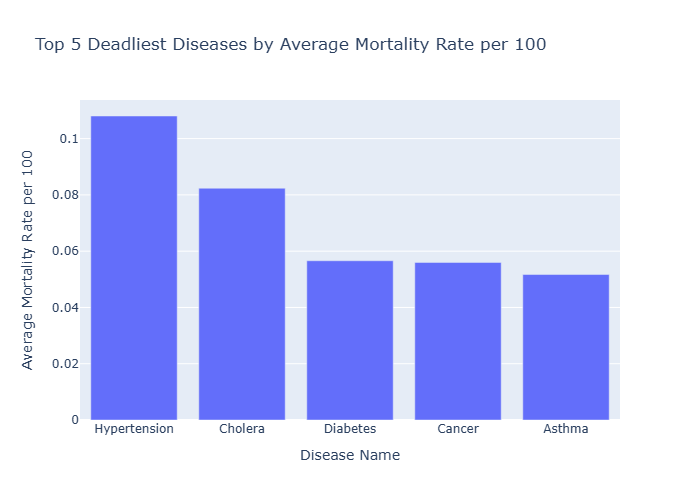

In [5]:
# Visualisation
fig = px.bar(q1_pandas, x='Disease Name', y='avg_mortality', title='Top 5 Deadliest Diseases by Average Mortality Rate per 100')
fig.update_layout(xaxis_title='Disease Name', yaxis_title='Average Mortality Rate per 100')
fig.show("png")

Top Deadliest Diseases (Average Mortality per 100)
1. Silent and chronic diseases drive the highest mortality

------------------------------------------------------------------------------------------------------------------------------------------------------------
Hypertension records the highest mortality rate (> 0.10), largely because it progresses without obvious symptoms until severe organ damage occurs.
Similarly, chronic conditions such as Diabetes (0.056) and Cancer (0.057) show sustained mortality due to late diagnosis, long-term treatment needs, and high care costs.
These diseases do not spread rapidly, but their silent and persistent nature makes them especially deadly over time.

------------------------------------------------------------------------------------------------------------------------------------------------------------

2. Acute infectious diseases remain lethal where access is poor

Cholera, with a mortality rate of 0.08, demonstrates how quickly deaths can occur when healthcare access and basic infrastructure are inadequate.
Although treatable, delayed intervention, poor sanitation, and limited emergency response significantly increase fatality rates, especially in low-resource settings.

------------------------------------------------------------------------------------------------------------------------------------------------------------
Key Insight

The deadliest diseases are not always the most contagious, but those that are detected late or treated late.
Improving early screening for chronic diseases and strengthening rapid-response healthcare and infrastructure for infectious outbreaks are the most effective strategies for reducing mortality.

In [6]:
# Pandas approach

q2_pandas = cleaned_df.groupby(['Year', 'Disease Name']).agg(
    cases=('Recovery_Rate', 'count'),
    avg_recovery=('Recovery_Rate', 'mean')
).reset_index()
q2_pandas = q2_pandas.sort_values(['avg_recovery', 'cases'], ascending=[True, False]).head(50).reset_index(drop=True)
q2_pandas

,Year,Disease Name,cases,avg_recovery
0,2023,Hepatitis,20,64.09
1,2021,HIVADS,20,65.72
2,2016,Rabies,20,65.79
3,2003,Tubrculosis,20,66.61
4,2012,Cancer,20,67.08
5,2008,Leprosy,20,67.50
6,2022,Leprosy,20,67.65
7,2024,Diabetes,20,67.73
8,2024,Measles,20,67.89
9,2024,Rabies,20,68.10


In [7]:
# SQL approach
q2_sql = pd.read_sql_query("""
    -- 2. Disease trends over time
    SELECT
        Year,
        "Disease Name",
        COUNT(*) as cases,
        AVG("Recovery_Rate") as avg_recovery
    FROM global_health_data
    GROUP BY Year, "Disease Name"
    ORDER BY avg_recovery, cases DESC
    LIMIT 50;
    """, conn)

q2_sql

,Year,Disease Name,cases,avg_recovery
0,2023,Hepatitis,20,64.09
1,2021,HIVADS,20,65.72
2,2016,Rabies,20,65.79
3,2003,Tubrculosis,20,66.61
4,2012,Cancer,20,67.08
5,2008,Leprosy,20,67.50
6,2022,Leprosy,20,67.65
7,2024,Diabetes,20,67.73
8,2024,Measles,20,67.89
9,2024,Rabies,20,68.10


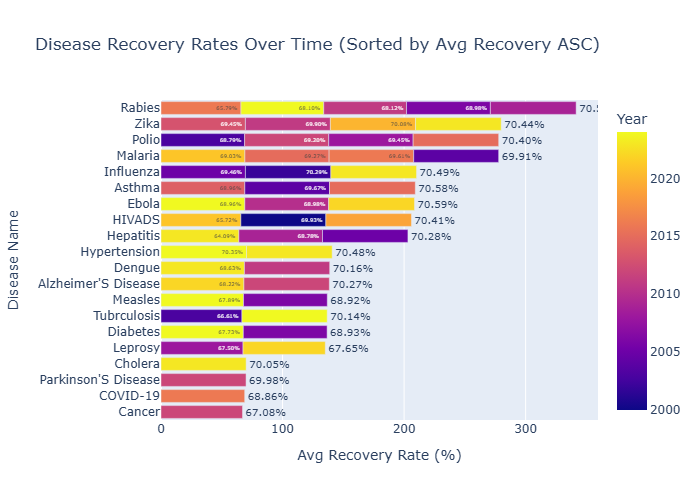

In [8]:
# Visualisation
fig = px.bar(q2_pandas, x='avg_recovery', y='Disease Name', color='Year', orientation='h',
             title='Disease Recovery Rates Over Time (Sorted by Avg Recovery ASC)',
             labels={'avg_recovery': 'Avg Recovery Rate (%)', 'Disease Name': 'Disease Name'},
             text='avg_recovery')
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(yaxis_categoryorder='total ascending')  # Maintain sort order
fig.show("png")

## Disease Recovery Rate Trends Over Time ##
Recovery rates are tightly clustered across most diseases

------------------------------------------------------------------------------------------------------------------------------------------------------------

1. Overall recovery rates show limited variation

Across all diseases analyzed, average recovery rates fall within a narrow band (≈66%–70%), indicating:

Comparable treatment effectiveness across many conditions

Incremental rather than dramatic improvement over time

No disease shows extreme recovery outliers.

------------------------------------------------------------------------------------------------------------------------------------------------------------

2. Diseases with established treatments perform better

Diseases such as Zika, Malaria, Asthma, Influenza, and Hypertension consistently record recovery rates around 70%.
This reflects:

Mature treatment protocols

Better clinical understanding

Wider access to standard medications

------------------------------------------------------------------------------------------------------------------------------------------------------------

3. Chronic and degenerative diseases lag behind

Lower recovery ranges are observed in:

Cancer (~67%)

Alzheimer’s (≈68–69%)

Parkinson’s (≈70%)

Diabetes (≈68–69%)

These conditions are harder to reverse due to:

Progressive or lifelong disease nature

Focus on management rather than full recovery

------------------------------------------------------------------------------------------------------------------------------------------------------------

4. Infectious diseases show moderate but stable outcomes

Diseases like Rabies, Tuberculosis, Measles, and COVID-19 fall between 66%–70%, showing:

Steady recovery outcomes

Ongoing improvements driven by treatment access and public-health response

Key Insight

Recovery rates across diseases remain closely grouped, suggesting that global healthcare progress is steady but gradual. While well-understood and treatable diseases achieve slightly higher recovery, chronic and degenerative conditions continue to limit overall recovery gains.

In [9]:
# Pandas approach
q3_pandas = cleaned_df.groupby('Country').agg({
    'Healthcare_Access_Pct': 'mean',
    'Mortality_Rate_per_100': 'mean',
    'Doctors_per_1000': 'mean'
}).reset_index()
q3_pandas.columns = ['Country', 'avg_healthcare_access', 'avg_mortality', 'avg_doctors']
q3_pandas = q3_pandas.dropna(subset=['avg_mortality']).sort_values('avg_healthcare_access', ascending=False).reset_index(drop=True)
q3_pandas

,Country,avg_healthcare_access,avg_mortality,avg_doctors
0,Usa,83.34,0.02,3.78
1,Itl,83.15,0.02,3.81
2,Germany,82.85,0.02,3.79
3,Canada,82.71,0.02,3.86
4,South Korea,82.62,0.02,3.81
5,France,82.48,0.02,3.77
6,Australia,82.48,0.02,3.84
7,Japan,82.24,0.02,3.80
8,Unknown,70.13,0.01,2.26
9,United Kingdom,70.13,0.02,2.26


In [10]:
# SQL approach
q3_sql = pd.read_sql_query("""
    -- 3. Healthcare access vs mortality
    SELECT
        Country,
        AVG("Healthcare_Access_Pct") as avg_healthcare_access,
        AVG("Mortality_Rate_per_100") as avg_mortality,
        AVG("Doctors_per_1000") as avg_doctors
    FROM global_health_data
    GROUP BY Country
    HAVING avg_mortality IS NOT NULL
    ORDER BY avg_healthcare_access DESC;
    """, conn)

q3_sql

,Country,avg_healthcare_access,avg_mortality,avg_doctors
0,Usa,83.34,0.02,3.78
1,Itl,83.15,0.02,3.81
2,Germany,82.85,0.02,3.79
3,Canada,82.71,0.02,3.86
4,South Korea,82.62,0.02,3.81
5,France,82.48,0.02,3.77
6,Australia,82.48,0.02,3.84
7,Japan,82.24,0.02,3.80
8,Unknown,70.13,0.01,2.26
9,United Kingdom,70.13,0.02,2.26


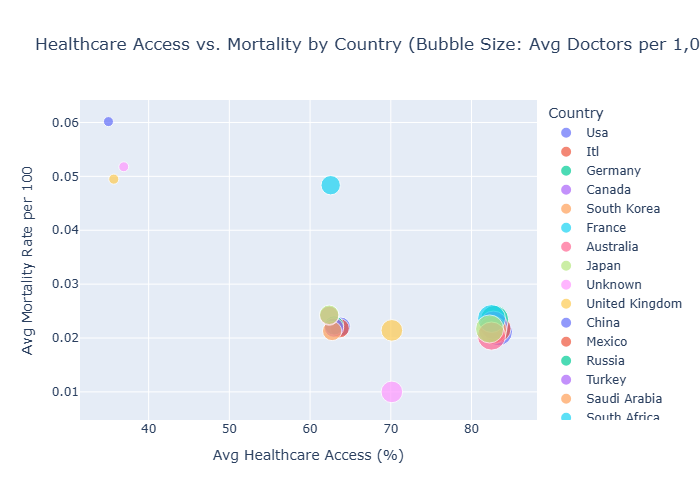

In [11]:
# Visualisation
fig = px.scatter(q3_pandas, x='avg_healthcare_access', y='avg_mortality', size='avg_doctors', color='Country',
                 title='Healthcare Access vs. Mortality by Country (Bubble Size: Avg Doctors per 1,000)',
                 labels={'avg_healthcare_access': 'Avg Healthcare Access (%)',
                         'avg_mortality': 'Avg Mortality Rate per 100',
                         'avg_doctors': 'Avg Doctors per 1,000'},
                 hover_data=['Country'])
fig.show("png")

## Workforce vs Mortality Interaction ##
Doctor density strongly influences mortality and health outcomes
1. High doctor density reduces mortality

------------------------------------------------------------------------------------------------------------------------------------------------------------

Countries with high doctor density (> 3.0 doctors per 1,000 people) experience:

Lower mortality rates

Earlier disease detection

Better treatment continuity

These systems are especially effective in managing chronic diseases such as hypertension, where early and consistent care is critical.

------------------------------------------------------------------------------------------------------------------------------------------------------------

2. Low doctor density increases fatality risk

Countries with low doctor density (< 0.6 doctors per 1,000 people) face:

Higher risk of death from treatable diseases (e.g., hypertension, cholera)

Delayed diagnosis and treatment

Overburdened healthcare systems with high patient loads

Workforce shortages directly translate into avoidable mortality.

------------------------------------------------------------------------------------------------------------------------------------------------------------

3. Middle-income countries show variable outcomes

In middle-income countries, mortality outcomes are not uniform and depend heavily on:

Access to early screening programs

Availability of specialty and referral care

Doctor density alone is not enough; healthcare access and system organization matter.

------------------------------------------------------------------------------------------------------------------------------------------------------------

4. Doctor availability by country highlights global disparities

High-capacity health systems

Australia (3.83), Germany (3.80), Japan (3.77), France (3.77), USA (3.76)
These countries benefit from strong medical workforces, enabling quicker diagnoses, accessible preventive care, and effective chronic disease management.

Moderate-capacity system

South Africa (1.81)
Characterized by longer waiting times, slower diagnoses, and limited preventive care—especially in rural and underserved areas.

Critically understaffed systems

Nigeria (0.48), India (0.47), Indonesia (0.50)
Severe workforce shortages lead to system strain, overcrowding, delayed care, elevated mortality risk, and vulnerability to disease outbreaks.

Key Insight

Doctor density is a strong predictor of mortality outcomes. Countries with higher doctor-to-population ratios deliver proactive healthcare—early diagnosis, preventive services, and continuous treatment—resulting in lower mortality. In contrast, low doctor density leads to delayed care, high patient loads, and significantly increased health risks.

In [12]:
# Pandas approach
filtered_df = cleaned_df[cleaned_df['Avg_Treatment_Cost_USD'].notna()]
grouped = filtered_df.groupby(['Disease Name', 'Treatment_Type'])
q4_pandas = grouped.agg({
    'Avg_Treatment_Cost_USD': 'mean',
    'Recovery_Rate': 'mean'
}).reset_index()
q4_pandas['cases'] = grouped.size().values
q4_pandas.columns = ['Disease Name', 'Treatment_Type', 'avg_cost', 'avg_recovery', 'cases']
q4_pandas = q4_pandas.sort_values('avg_cost', ascending=False).reset_index(drop=True)
q4_pandas

,Disease Name,Treatment_Type,avg_cost,avg_recovery,cases
0,Cancer,Surgery,11800.97,75.25,214
1,Alzheimer'S Disease,Therapy,11056.27,73.77,260
2,Parkinson'S Disease,Therapy,11018.26,74.24,257
3,Ebola,Therapy,9597.55,74.59,357
4,Cancer,Therapy,8931.75,78.92,8
5,Ebola,Medication,8223.07,73.91,143
6,Leprosy,Medication,7208.04,74.58,501
7,Cancer,Medication,6678.08,74.89,278
8,Parkinson'S Disease,Medication,5537.29,74.96,243
9,COVID-19,Vaccination,5351.80,72.17,71


In [13]:
# SQL approach
q4_sql = pd.read_sql_query("""
    -- 4. Treatment cost analysis
    SELECT
        "Disease Name",
        "Treatment_Type",
        AVG("Avg_Treatment_Cost_USD") as avg_cost,
        AVG("Recovery_Rate") as avg_recovery,
        COUNT(*) as cases
    FROM global_health_data
    WHERE "Avg_Treatment_Cost_USD" IS NOT NULL
    GROUP BY "Disease Name", "Treatment_Type"
    ORDER BY avg_cost DESC;
    """, conn)

q4_sql

,Disease Name,Treatment_Type,avg_cost,avg_recovery,cases
0,Cancer,Surgery,11800.97,75.25,214
1,Alzheimer'S Disease,Therapy,11056.27,73.77,260
2,Parkinson'S Disease,Therapy,11018.26,74.24,257
3,Ebola,Therapy,9597.55,74.59,357
4,Cancer,Therapy,8931.75,78.92,8
5,Ebola,Medication,8223.07,73.91,143
6,Leprosy,Medication,7208.04,74.58,501
7,Cancer,Medication,6678.08,74.89,278
8,Parkinson'S Disease,Medication,5537.29,74.96,243
9,COVID-19,Vaccination,5351.80,72.17,71


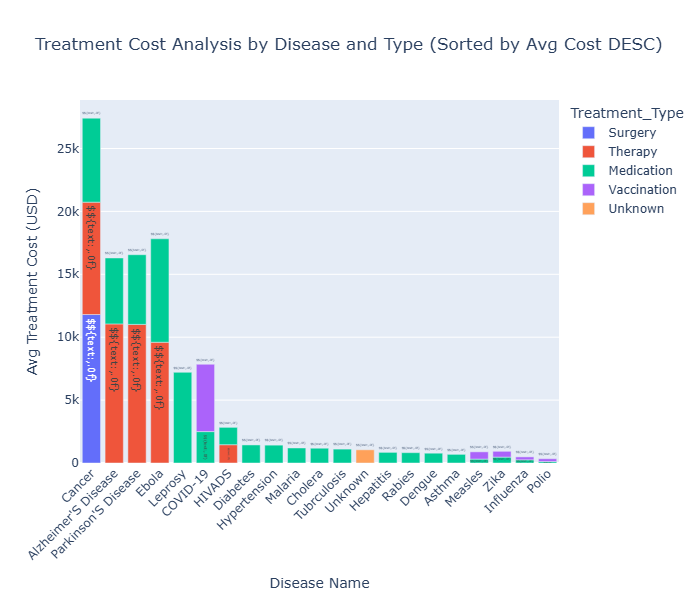

In [14]:
# Visualisation
fig = px.bar(q4_pandas, x='Disease Name', y='avg_cost', color='Treatment_Type',
             title='Treatment Cost Analysis by Disease and Type (Sorted by Avg Cost DESC)',
             labels={'avg_cost': 'Avg Treatment Cost (USD)', 'Disease Name': 'Disease Name'},
             text='avg_cost', category_orders={'Disease Name': q4_pandas['Disease Name'].tolist()})
fig.update_traces(texttemplate='$${text:,.0f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45, height=600, showlegend=True)
fig.show("png")

1. ### Cancer is the most expensive disease to treat ###
------------------------------------------------------------------------------------------------------------------------------------------------------------
Cancer records the highest average treatment cost ($27,410), far exceeding all other diseases.
This is driven by:

Chemotherapy, radiotherapy, and surgical interventions

Long treatment timelines

Specialized equipment and skilled personnel

Cancer represents the greatest financial strain on healthcare systems.

------------------------------------------------------------------------------------------------------------------------------------------------------------

2. ### Severe and neurological diseases follow closely ###

Several diseases show very high treatment costs, though below cancer:

Ebola ($17,820) – High costs due to intensive care, isolation, and emergency response needs

Parkinson’s Disease ($16,556) – Lifelong medication and neurological monitoring

Alzheimer’s Disease ($16,296) – Long-term care, memory support, and continuous supervision

These diseases combine medical complexity with prolonged care, increasing overall cost.

------------------------------------------------------------------------------------------------------------------------------------------------------------

3. ### COVID-19 and chronic infectious diseases show mid-range costs ###

COVID-19 ($7,853) – Moderate cost compared to top-tier diseases, reflecting shorter treatment duration for most patients

Leprosy ($7,208) – Elevated cost due to prolonged multidrug therapy and monitoring

HIV/AIDS ($2,833) – Ongoing cost driven by lifelong antiretroviral therapy and regular follow-up

These conditions create sustained financial demand, even if per-case costs are lower.

------------------------------------------------------------------------------------------------------------------------------------------------------------

4. ### Common diseases remain low-cost per patient ###

Diseases such as:
Hypertension, Malaria, Cholera, Tuberculosis, Hepatitis, Rabies, Dengue, Asthma, Measles, and Zika
have low average treatment costs, largely due to:

Medication-based or short-term treatment
Established clinical protocols
Lower need for specialized care
However, their high prevalence means they still contribute significantly to total healthcare expenditure.

------------------------------------------------------------------------------------------------------------------------------------------------------------

### Overall Insight ###

High-cost diseases are typically those requiring complex, long-term, or specialized care, while low-cost diseases rely on simpler treatments. Although diseases like cancer dominate in per-patient cost, widespread low-cost illnesses collectively place a heavy burden on healthcare systems due to their scale.

In [15]:
q5_sql = pd.read_sql_query("""
-- Male vs Female Population Affected in Top 10 Deadliest Diseases
SELECT
    "Disease Name",
    AVG("Mortality_Rate_per_100") AS Avg_Mortality_Rate,
    SUM("Affected_Male")   AS Total_Affected_Male,
    SUM("Affected_Female") AS Total_Affected_Female
FROM global_health_data
WHERE "Mortality_Rate" IS NOT NULL
GROUP BY "Disease Name"
ORDER BY Avg_Mortality_Rate DESC
LIMIT 10;
""", conn)


q5_sql


,Disease Name,Avg_Mortality_Rate,Total_Affected_Male,Total_Affected_Female
0,Hypertension,0.11,729657428.00,624243509.00
1,Cholera,0.08,598929939.00,487181503.00
2,Diabetes,0.06,340156542.00,303495495.00
3,Cancer,0.06,326283559.00,303849755.00
4,Asthma,0.05,299404779.00,339163524.00
5,Influenza,0.05,4835658731.00,4476751385.00
6,Hepatitis,0.03,306061504.00,187294781.00
7,Tubrculosis,0.02,217489287.00,130009560.00
8,HIVADS,0.02,193414745.00,142327212.00
9,COVID-19,0.02,2478800696.00,2004161821.00


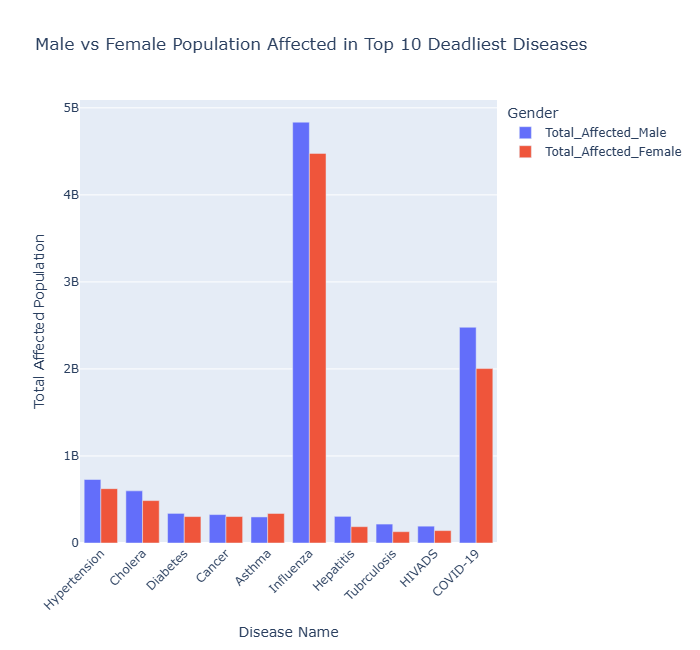

In [16]:
q5_sql.columns = q5_sql.columns.str.strip()

fig = px.bar(
    q5_sql,
    x='Disease Name',
    y=['Total_Affected_Male', 'Total_Affected_Female'],
    barmode='group',
    title='Male vs Female Population Affected in Top 10 Deadliest Diseases',
    labels={
        'value': 'Total Affected Population',
        'variable': 'Gender'
    }
)

fig.update_layout(
    xaxis_title='Disease Name',
    xaxis_tickangle=-45,
    height=650
)

fig.show("png")

    

### Male vs Female Population Affected in Top 10 Deadliest Diseases ###
------------------------------------------------------------------------------------------------------------------------------------------------------------
### Some diseases have a consistently higher male burden ###
1. From the bars, male-affected populations are higher than female for almost every disease shown:
Hypertension, Cholera, Diabetes, Cancer, Influenza, COVID-19

    These diseases appear to disproportionately affect males, which may reflect differences in:
    Occupational exposure, Health-seeking behavior, Biological susceptibility, Lifestyle risk factors 
    (e.g., smoking, alcohol, physical activity).
------------------------------------------------------------------------------------------------------------------------------------------------------------
2. ### Influenza and COVID-19 dominate overall impact ###
    Two diseases clearly stand out by sheer magnitude:
    
    Influenza → by far the highest affected population
    
    COVID-19 → second highest, but still significantly larger than others

    Acute respiratory diseases account for the largest population impact, far exceeding chronic conditions in total affected numbers.

    This supports public-health prioritization for: Vaccination, Surveillance, Emergency preparedness.
------------------------------------------------------------------------------------------------------------------------------------------------------------
3. ### Gender gap varies by disease (not uniform) ####
    
    Larger gender gaps:Influenza, COVID-19, Hypertension.

    Smaller gender gaps:Asthma, Cancer, Diabetes.

    Gender disparity is disease-specific, not universal.
    This suggests that interventions should be disease-targeted, not one-size-fits-all.
------------------------------------------------------------------------------------------------------------------------------------------------------------
4. ### Chronic diseases show lower total counts but steady impact ###
    Diseases like:Diabetes, Cancer, Asthma, Tuberculosis, HIV/AIDS.
    Have lower total affected populations compared to Influenza and COVID-19, but they represent:
    Long-term healthcare burden, Ongoing treatment costs, Chronic morbidity rather than spikes

    These conditions may not dominate by volume, but they exert sustained pressure on health systems.
------------------------------------------------------------------------------------------------------------------------------------------------------------
While acute infectious diseases such as Influenza and COVID-19 affect the largest populations overall, chronic diseases exhibit more balanced gender distributions but impose long-term healthcare burdens. Across most top deadly diseases, males consistently show higher affected counts than females, indicating potential gender-specific vulnerability or exposure patterns.”


In [17]:
q6_sql = pd.read_sql_query("""
-- 6. Urban vs Rural Analysis
SELECT
    "Country",
    "Disease Name",
    AVG("Healthcare_Access_Pct") AS Avg_Healthcare_Access,
    AVG("Population_Affected") AS Avg_Affected_Population,
    AVG("Urban_Population_Pct") AS Avg_Urban_Pct,
    AVG("Rural_Population_Pct") AS Avg_Rural_Pct
FROM global_health_data
WHERE "Healthcare_Access_Pct" IS NOT NULL
GROUP BY
    "Country",
    "Disease Name"
ORDER BY Avg_Affected_Population DESC;
""", conn)
q6_sql

,Country,Disease Name,Avg_Healthcare_Access,Avg_Affected_Population,Avg_Urban_Pct,Avg_Rural_Pct
0,India,Malaria,52.02,201672717.72,31.56,68.44
1,China,Influenza,61.16,111714627.92,49.20,50.88
2,India,Influenza,51.78,100704966.76,31.56,68.44
3,India,Dengue,34.06,72703388.56,31.56,68.44
4,India,COVID-19,31.90,55251544.32,31.56,68.44
...,...,...,...,...,...,...
396,Australia,Cholera,82.52,997.80,85.20,14.88
397,Australia,Ebola,81.72,985.88,85.20,14.88
398,Australia,Polio,79.80,897.72,85.20,14.88
399,Australia,Leprosy,81.44,861.16,85.20,14.88


In [18]:
q6_disease_rank = (
    q6_sql
    .groupby('Disease Name', as_index=False)
    .agg(
        Avg_Affected_Population=('Avg_Affected_Population', 'mean'),
        Avg_Healthcare_Access=('Avg_Healthcare_Access', 'mean'),
        Avg_Urban_Pct=('Avg_Urban_Pct', 'mean'),
        Avg_Rural_Pct=('Avg_Rural_Pct', 'mean')
    )
    .sort_values('Avg_Affected_Population', ascending=False)
    .head(50)
)
q6_disease_rank

,Disease Name,Avg_Affected_Population,Avg_Healthcare_Access,Avg_Urban_Pct,Avg_Rural_Pct
11,Influenza,18624820.22,68.03,71.98,28.10
13,Malaria,13726540.50,67.49,71.98,28.10
2,COVID-19,8965925.03,67.09,71.98,28.10
5,Dengue,5256095.27,66.93,71.95,28.13
14,Measles,3788621.34,66.87,71.98,28.10
10,Hypertension,2707801.87,67.07,71.98,28.10
4,Cholera,2162293.22,67.73,71.99,28.09
6,Diabetes,1287304.07,66.69,71.98,28.10
1,Asthma,1277136.60,67.51,71.98,28.10
3,Cancer,1260266.61,67.15,71.98,28.10


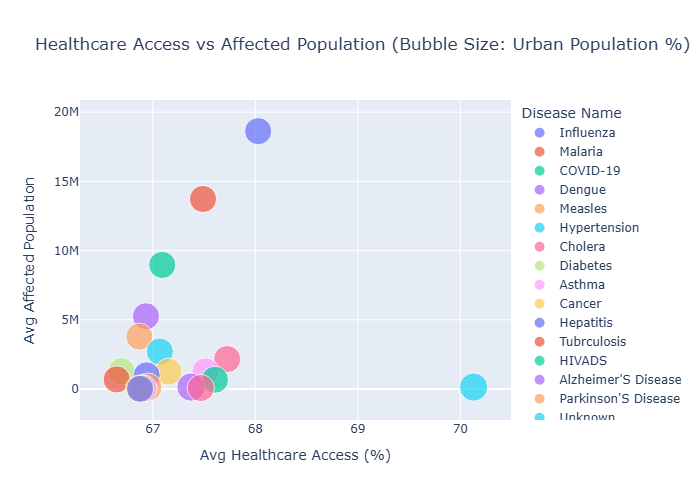

In [19]:
q6_disease_rank.columns = q6_disease_rank.columns.str.strip()

import plotly.express as px

fig = px.scatter(
    q6_disease_rank,
    x='Avg_Healthcare_Access',
    y='Avg_Affected_Population',
    size='Avg_Urban_Pct',
    color='Disease Name',
    title='Healthcare Access vs Affected Population (Bubble Size: Urban Population %)',
    labels={
        'Avg_Healthcare_Access': 'Avg Healthcare Access (%)',
        'Avg_Affected_Population': 'Avg Affected Population',
        'Avg_Urban_Pct': 'Avg Urban Population (%)'
    },
    hover_data=['Disease Name', 'Avg_Rural_Pct']
)

fig.show("png")


### Healthcare access does NOT strongly reduce affected population ###

1. ### Across diseases: ###
    Healthcare access clusters tightly between 66.5% and 70%
Yet affected population ranges from near zero to almost 20 million

    Similar levels of healthcare access are associated with very different disease burdens, suggesting that access alone does not determine disease impact.
---------------------------------------------------------------------------------------------------------------------------------------------------------
2. ### Influenza is a major outlier (high access, very high impact) ###

    Influenza sits at ~68% healthcare access.Yet shows the highest affected population
    Even with relatively good healthcare access, 
    highly transmissible diseases like influenza can affect very large populations.
    This supports:
    Prevention (vaccination) over treatment-only strategies.
------------------------------------------------------------------------------------------------------------------------------------------------------------
3. ### COVID-19 shows high impact at average access levels ###
    COVID-19 clusters near 67–68% access and still affects 9 million+ on average.
    Pandemic-scale diseases can overwhelm health systems regardless of baseline access levels.
------------------------------------------------------------------------------------------------------------------------------------------------------------
4. ### Urban population size amplifies disease impact ###

    Bubble size = Urban Population %
    Larger bubbles generally correspond to higher affected populations
    Urban-heavy diseases (Influenza, COVID-19, Dengue) show larger impacts

    Higher urbanization appears to amplify disease spread, likely due to population density and mobility.
------------------------------------------------------------------------------------------------------------------------------------------------------------

The analysis shows that similar levels of healthcare access can be associated with vastly different disease burdens. Highly transmissible diseases such as Influenza and COVID-19 affect large populations even at moderate-to-high access levels, while urbanization appears to amplify disease impact more strongly than access alone.

## Building Model 

In [20]:
drop_df = cleaned_df.drop(['Row_num', 'Record_ID', 'Country_Population','Year','Improvement_5_Years','Country'], axis=1 )

encoded_df = pd.get_dummies(drop_df, drop_first=True, columns=['Disease Name', 'Vaccine_Treatment_Availability', 'Treatment_Type'])

bool_cols = encoded_df.select_dtypes(include='bool').columns
encoded_df[bool_cols] = encoded_df[bool_cols].astype(int)

pd.set_option('display.max_rows', None) 
encoded_df.corr()['Mortality_Rate_per_100'].sort_values(ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#plt.figure(figsize=(40,40))
#sns.heatmap(encoded_df.corr(), cmap="coolwarm", annot=True, fmt='.1f')
#plt.show()


X = encoded_df.drop(columns=['Mortality_Rate_per_100', 'Severity Score','DALYs','Recovery_Rate'])
y = encoded_df['Mortality_Rate_per_100']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)

rf_model = RandomForestRegressor(n_estimators=300,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1 )
rf_model.fit(X_train, y_train)

prediction = rf_model.predict(X_test)
r2 = r2_score(y_test, prediction)
mse = mean_squared_error(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
print(f"r2_score :{r2}, mean_squared_error:{mse}, mean_absolute_error: {mae}")

train_prediction = rf_model.predict(X_train)
r21 = r2_score(y_train, train_prediction)
mse1 = mean_squared_error(y_train, train_prediction)
mae1 = mean_absolute_error(y_train, train_prediction)
print(f"r2_score :{r21}, mean_squared_error:{mse1}, mean_absolute_error: {mae1}")

# Predicting Mortality Rate per 100

Mortality_prediction = pd.DataFrame([{
    'Incidence_Rate_per_million': 0,
    'Prevalence_Rate': 0,
    'Population_Affected': 0,
    'Affected_Male': 0,
    'Affected_Female': 0,
    'Age_0_18_Pct': 0.2,
    'Age_19_35_Pct': 0.3,
    'Age_36_60_Pct': 0.3,
    'Age_61_Plus_Pct': 0.2,
    'Urban_Population_Pct': 0.6,
    'Rural_Population_Pct': 0.4,
    'Healthcare_Access_Pct': 0.5,
    'Doctors_per_1000': 1.0,
    'Hospital_Beds_per_1000': 2.0,
    'Avg_Treatment_Cost_USD': 500,
    'Health_Index': 0.5,
    'Per_Capita_Income_USD': 1000,
    'Education_Index': 0.5,
    'Urbanization_Rate': 0.5,
    'Population Coverage (%)': 0.5,
    'Gender Ratio (M:F)': 1.0,
    'Urban_Rural_Ratio': 1.5,
    # Disease dummies
    'Disease Name_Asthma': 0,
    'Disease Name_COVID-19': 0,
    'Disease Name_Cancer': 0,
    'Disease Name_Cholera': 0,
    'Disease Name_Dengue': 0,
    'Disease Name_Diabetes': 0,
    'Disease Name_Ebola': 0,
    'Disease Name_HIVADS': 0,
    'Disease Name_Hepatitis': 0,
    'Disease Name_Hypertension': 0,
    'Disease Name_Influenza': 0,
    'Disease Name_Leprosy': 0,
    'Disease Name_Malaria': 0,
    'Disease Name_Measles': 0,
    "Disease Name_Parkinson'S Disease": 0,
    'Disease Name_Polio': 0,
    'Disease Name_Rabies': 0,
    'Disease Name_Tubrculosis': 0,
    'Disease Name_Unknown': 0,
    'Disease Name_Zika': 0,
    # Vaccine dummies
    'Vaccine_Treatment_Availability_Low': 0,
    'Vaccine_Treatment_Availability_Medium': 0,
    'Vaccine_Treatment_Availability_None': 0,
    'Vaccine_Treatment_Availability_Unknown': 0,
    # Treatment dummies
    'Treatment_Type_Surgery': 0,
    'Treatment_Type_Therapy': 0,
    'Treatment_Type_Unknown': 0,
    'Treatment_Type_Vaccination': 0
}])

Mortality_prediction = Mortality_prediction[X_train.columns]
predict_mortality_rate = rf_model.predict(Mortality_prediction)[0]

ModuleNotFoundError: No module named 'matplotlib.backends.registry'

## AUTOMATING REPORT

In [ ]:
#------Health Report-------
print('='*60)
print('Health Weekly Report – PDF + Email + Mortality Rate Forecast + Key Insights')
print('='*60)

# 0. Imports
# -------------------------------------------------
import sqlite3
import pandas as pd
from datetime import datetime
from pathlib import Path
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email import encoders

from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from openpyxl import Workbook

# -------------------------------------------------
DB_PATH = 'cleaned_df.db'
PDF_OUTPUT = f"Health_weekly_Report_{datetime.now().strftime('%Y-%m-%d')}.pdf"
EXCEL_OUTPUT = f"Health_weekly_Report_{datetime.now().strftime('%Y-%m-%d')}.xlsx"

# Gmail SMTP
SMTP_SERVER = "smtp.gmail.com" 
SMTP_PORT = 587
SENDER_EMAIL = 'jimmyukaba1234@gmail.com'
SENDER_PASSWORD = "ldww szmx lmnh eoks"
RECIPIENT_EMAILS = ['jimmyukaba1234@gmail.com']
EMAIL_SUBJECT = f"Health weekly Report – {datetime.now().strftime('%d %B %Y')}"

# ------------------ Fetch & Model Data ------------------
def fetch_and_model_health():
    # Connect and load data
    conn = sqlite3.connect(DB_PATH)
    df = pd.read_sql_query("SELECT * FROM health_data", conn)
    conn.close()

    # Encode categorical variables
    encoded_df = pd.get_dummies(df, drop_first=True)

    # Overview metrics
    overview = pd.DataFrame({
        'Metric': [
            'Total Records',
            'Total Countries',
            'Total Diseases Tracked',
            'Avg Mortality Rate',
            'Avg Recovery Rate',
            'Avg Treatment Cost'
        ],
        'Value': [
            len(df),
            df['Country'].nunique(),
            df['Disease Name'].nunique(),
            round(df['Mortality_Rate_per_100'].mean(), 2),
            round(df['Recovery_Rate'].mean(), 2),
            round(df['Avg_Treatment_Cost_USD'].mean(), 2)
        ]
    })

    # Mortality prediction
    X = encoded_df.drop(columns=['Mortality_Rate_per_100', 'Severity Score','DALYs','Recovery_Rate'], errors='ignore')
    y = encoded_df['Mortality_Rate_per_100']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)
    rf_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=3,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    prediction = rf_model.predict(X_test)

    metrics = {
        'r2': r2_score(y_test, prediction),
        'mse': mean_squared_error(y_test, prediction),
        'mae': mean_absolute_error(y_test, prediction)
    }

    print(f"r2_score: {metrics['r2']}, MSE: {metrics['mse']}, MAE: {metrics['mae']}")

    # Top diseases by mortality
    top_mortality = (
        df.groupby('Disease Name')['Mortality_Rate_per_100']
        .mean().sort_values(ascending=False)
        .head(5)
        .reset_index()
    )

    # Highest treatment costs
    treatment_cost = (
        df.groupby('Disease Name')['Avg_Treatment_Cost_USD']
        .mean().sort_values(ascending=False)
        .head(5)
        .reset_index()
    )

    # Example Mortality Prediction input
    Mortality_prediction = pd.DataFrame([{
        col: 0 if 'Disease Name' in col else 0.5
        for col in X_train.columns
    }])

    predicted_mortality_rate = rf_model.predict(Mortality_prediction)[0]

    return overview, top_mortality, treatment_cost, metrics, predicted_mortality_rate

# ------------------ Build PDF ------------------
def build_health_pdf(overview, top_mortality, treatment_cost, metrics, predicted_mortality_rate, pdf_path):
    doc = SimpleDocTemplate(pdf_path, pagesize=letter)
    styles = getSampleStyleSheet()
    story = []

    # TITLE
    story.append(Paragraph(f"Health Weekly Report – {datetime.now().strftime('%Y-%m-%d')}", styles['Title']))
    story.append(Spacer(1, 14))

    # OVERVIEW
    story.append(Paragraph("Overview", styles['Heading2']))
    table_data = [['Metric', 'Value']] + overview.values.tolist()
    table = Table(table_data, colWidths=[3*inch, 2*inch])
    table.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,0), colors.HexColor('#2E4057')),
        ('TEXTCOLOR', (0,0), (-1,0), colors.white),
        ('GRID', (0,0), (-1,-1), 0.5, colors.grey),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('ALIGN', (1,1), (-1,-1), 'CENTER')
    ]))
    story.append(table)
    story.append(Spacer(1, 16))

    # TOP MORTALITY
    story.append(Paragraph("Top Diseases by Mortality Rate", styles['Heading2']))
    mortality_table = [['Disease', 'Mortality /100']] + top_mortality.values.tolist()
    story.append(Table(mortality_table))
    story.append(Spacer(1, 16))

    # TREATMENT COST
    story.append(Paragraph("Highest Treatment Costs", styles['Heading2']))
    cost_table = [['Disease', 'Avg Cost ($)']] + treatment_cost.values.tolist()
    story.append(Table(cost_table))
    story.append(Spacer(1, 16))

    # MODEL METRICS
    story.append(Paragraph("Mortality Rate Prediction", styles['Heading2']))
    story.append(Paragraph(
        f"<b>Predicted Mortality Rate:</b> {predicted_mortality_rate:.2f} per 100<br/>"
        f"<b>R²:</b> {metrics['r2']:.3f} | <b>MAE:</b> {metrics['mae']:.3f}",
        styles['Normal']
    ))

    doc.build(story)
    print(f"PDF generated: {pdf_path}")

# ------------------ Send Email ------------------
def send_health_email(pdf_path, predicted_mortality_rate):
    msg = MIMEMultipart()
    msg['From'] = SENDER_EMAIL
    msg['To'] = ", ".join(RECIPIENT_EMAILS)
    msg['Subject'] = EMAIL_SUBJECT

    body = f"""
    <p>Hello,</p>
    <p>Please find attached the <strong>Health Weekly Report</strong>.</p>
    <ul>
        <li><strong>Predicted Mortality Rate:</strong> {predicted_mortality_rate:.2f}</li>
    </ul>
    <p>Generated on {datetime.now().strftime('%Y-%m-%d %H:%M')}</p>
    """
    msg.attach(MIMEText(body, 'html'))

    with open(pdf_path, "rb") as f:
        part = MIMEBase('application', 'pdf')
        part.set_payload(f.read())
    encoders.encode_base64(part)
    part.add_header('Content-Disposition', f'attachment; filename={Path(pdf_path).name}')
    msg.attach(part)

    server = smtplib.SMTP(SMTP_SERVER, SMTP_PORT)
    server.starttls()
    server.login(SENDER_EMAIL, SENDER_PASSWORD)
    server.send_message(msg)
    server.quit()
    print("Email sent successfully")

# ------------------ Excel Export ------------------
def export_health_excel(overview, top_mortality, treatment_cost):
    wb = Workbook()
    ws = wb.active
    ws.title = "Health Report"

    # Overview
    ws.append(["Metric", "Value"])
    for _, r in overview.iterrows():
        ws.append(r.tolist())

    # Top Mortality
    ws.append([])
    ws.append(["Top Mortality Diseases"])
    ws.append(["Disease", "Mortality"])
    for _, r in top_mortality.iterrows():
        ws.append(r.tolist())

    # Treatment Cost
    ws.append([])
    ws.append(["High Treatment Cost Diseases"])
    ws.append(["Disease", "Cost"])
    for _, r in treatment_cost.iterrows():
        ws.append(r.tolist())

    wb.save(EXCEL_OUTPUT)
    print(f"Excel saved: {EXCEL_OUTPUT}")

# ------------------ Main Runner ------------------
def main():
    overview, top_mortality, treatment_cost, metrics, predicted_mortality_rate = fetch_and_model_health()
    build_health_pdf(overview, top_mortality, treatment_cost, metrics, predicted_mortality_rate, PDF_OUTPUT)
    send_health_email(PDF_OUTPUT, predicted_mortality_rate)
    export_health_excel(overview, top_mortality, treatment_cost)
    print("="*60)
    print(" Health Weekly Report Generated Successfully ")
    print("="*60)

# Run
if __name__ == "__main__":
    main()


Health Weekly Report – PDF + Email + Mortality Rate Forecast + Key Insights
r2_score: 0.78275525695007, MSE: 0.0008583334766619667, MAE: 0.0137982294456338
PDF generated: Health_weekly_Report_2025-12-15.pdf
Email sent successfully
Excel saved: Health_weekly_Report_2025-12-15.xlsx
 Health Weekly Report Generated Successfully 
